🎯 Enhanced VoxConverse Diarization Pipeline
🚀 RUNNING COMPLETE ENHANCED DIARIZATION PIPELINE
📁 STEP 0: Understanding VoxConverse Dataset Structure
Checking dataset paths:
   Dev Audio: ✓ /kaggle/input/voxconverse-dataset/voxconverse_dev_wav/audio
      Files found: 216
      Sample: azisu.wav
   Test Audio: ✓ /kaggle/input/voxconverse-dataset/voxconverse_test_wav/voxconverse_test_wav
      Files found: 232
      Sample: fpfvy.wav
   Labels: ✓ /kaggle/input/voxconverse-dataset/labels/dev
      Files found: 216
      Sample: bwzyf.rttm

Dataset Statistics:
   Dev audio files: 216
   Test audio files: 232
   Label files: 216

Dataset Mapping Created:
   Matched audio-label pairs: 216
   Total speaker segments: 8268
   Average speakers per recording: 4.50
   Speaker count range: 1 - 20

✅ Dataset structure analysis completed

🎵 STEP 1: Loading Real Audio from VoxConverse Dataset
Loading file: bwzyf
✅ Loaded audio: 80.17s, 4 speakers
   Speakers: ['spk00', 'spk01', 'spk02', 'spk03']
   Audi

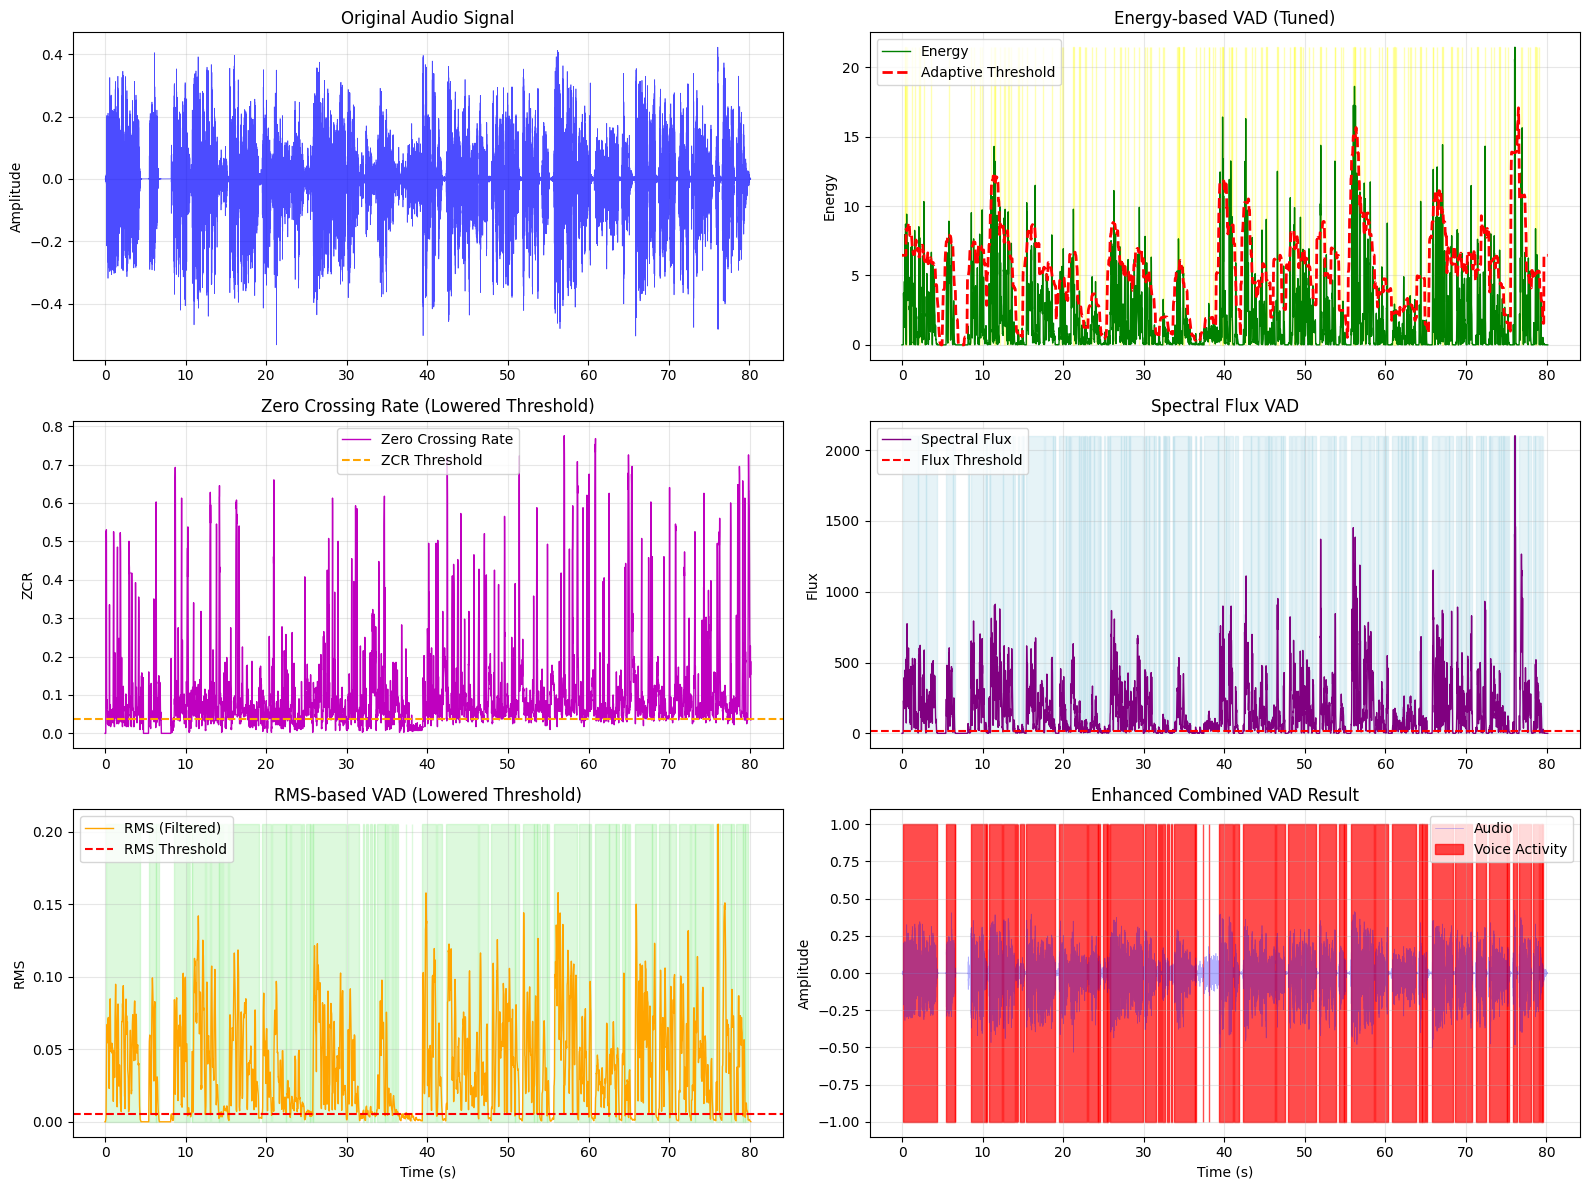

✅ Enhanced VAD completed:
   Combined voice activity: 79.7% of audio (target: 15-25%)
   Energy method: 5.1%
   Spectral method: 70.7%
   Rms method: 80.0%
   Flux method: 75.0%

🔍 ENHANCED STEP 3: Advanced Audio Feature Extraction
   Extracting comprehensive feature set...


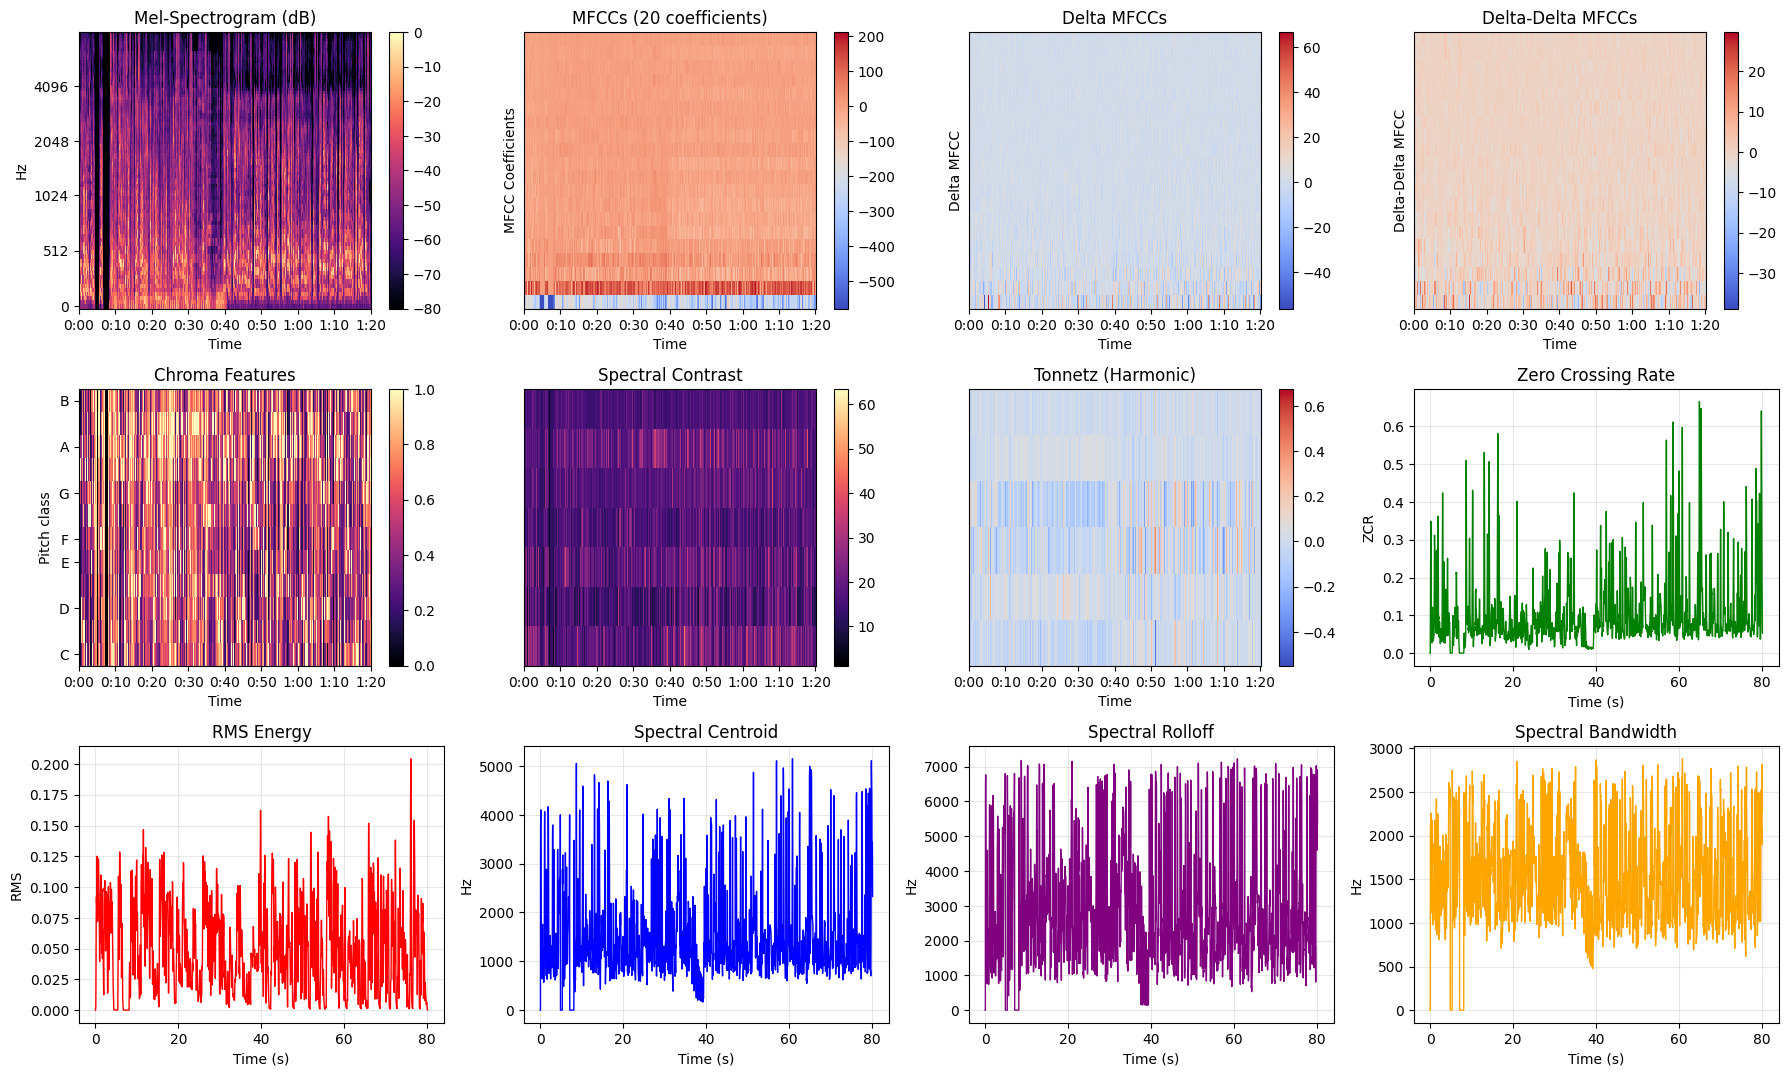

✅ Enhanced feature extraction completed
   MFCCs shape: (20, 2506)
   Delta MFCCs shape: (20, 2506)
   Total features: MFCCs(20) + Delta(20) + Delta2(20) + Others
   Feature time frames: 2506

🎯 ENHANCED STEP 4: Multi-Scale Speaker Embeddings
   Combined feature matrix shape: (90, 2506)
   Processing 1.5s windows...
   Processing 3.0s windows...
   Processing 6.0s windows...
✅ Multi-scale embeddings created:
   Total embeddings: 185
   Embedding dimension: 990
   Window sizes used: [1.5, 3.0, 6.0]
   Normalization: RobustScaler
   Creating embedding visualizations...


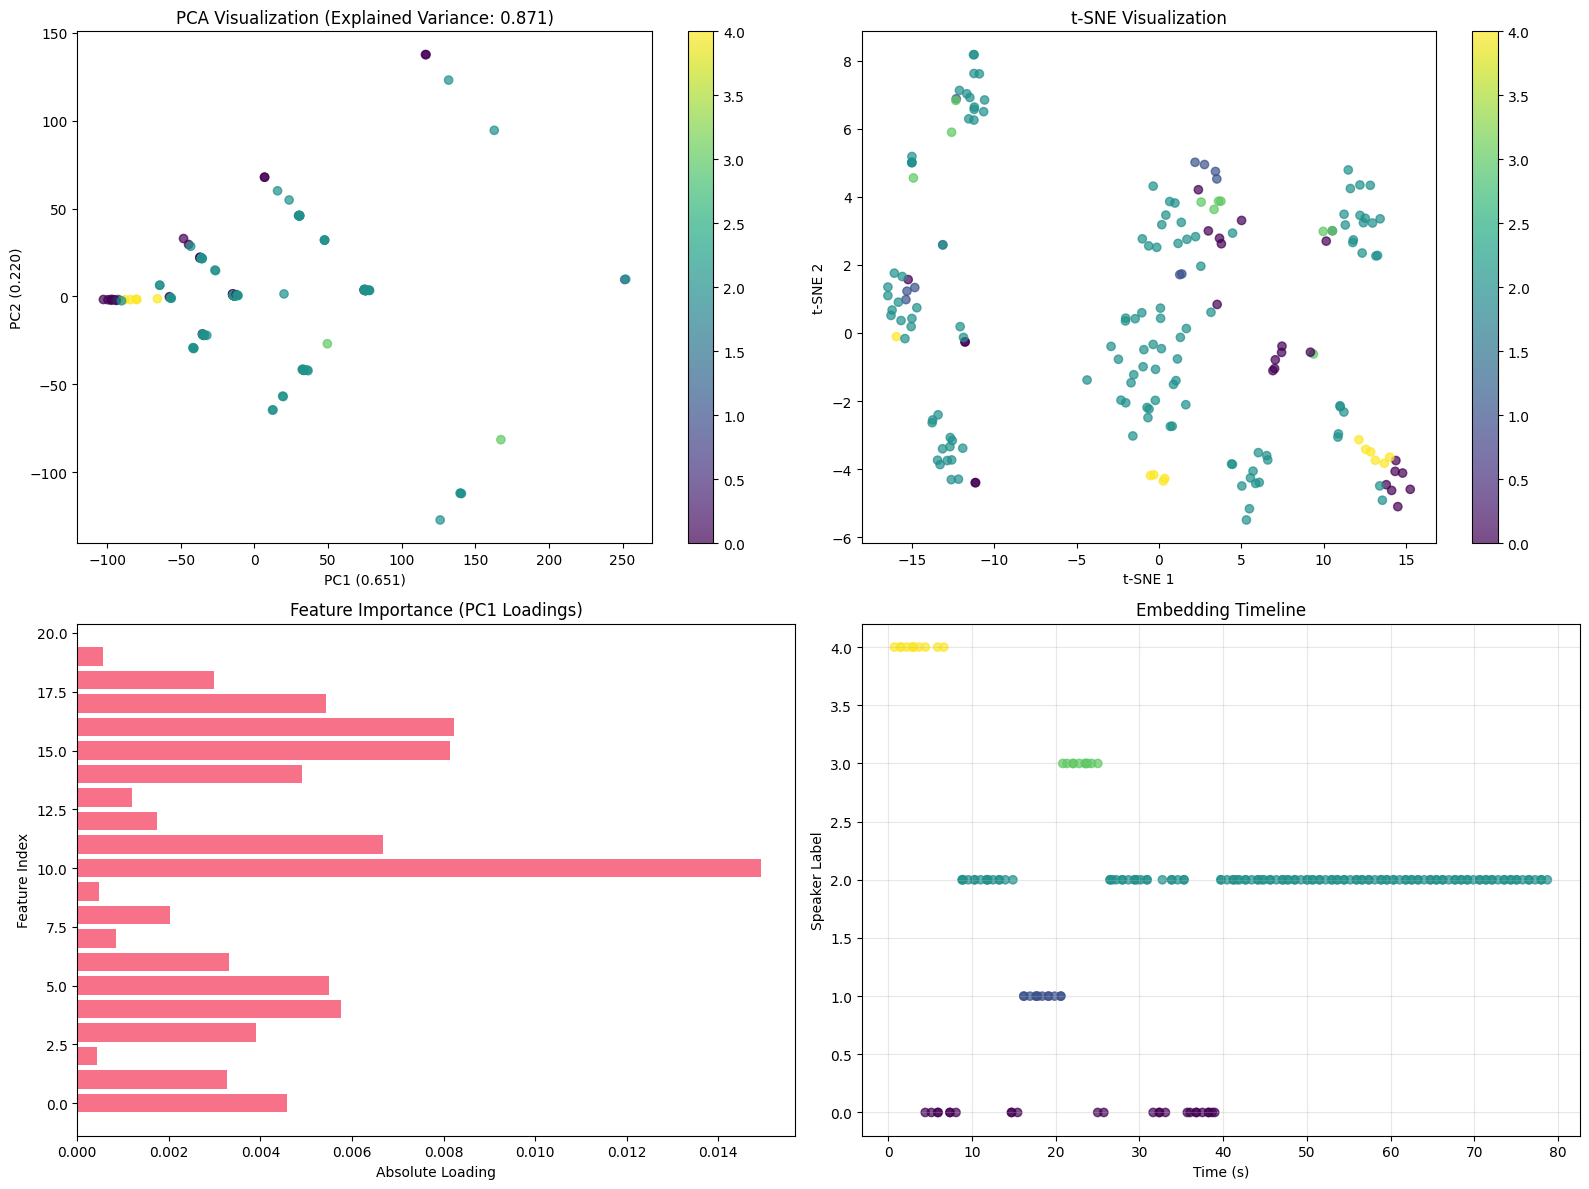


🔬 ENHANCED STEP 5: Optimized Clustering with Hyperparameter Tuning
   Testing K-Means with multiple configurations...
   Testing Gaussian Mixture Models...
   Testing DBSCAN with parameter optimization...

   Selecting best models...

✅ Clustering optimization completed:
   Total configurations tested: 99
   Best K-Means: k=3, silhouette=0.445
   Best GMM: k=2, silhouette=0.434
   Overall best: KMeans, silhouette=0.445


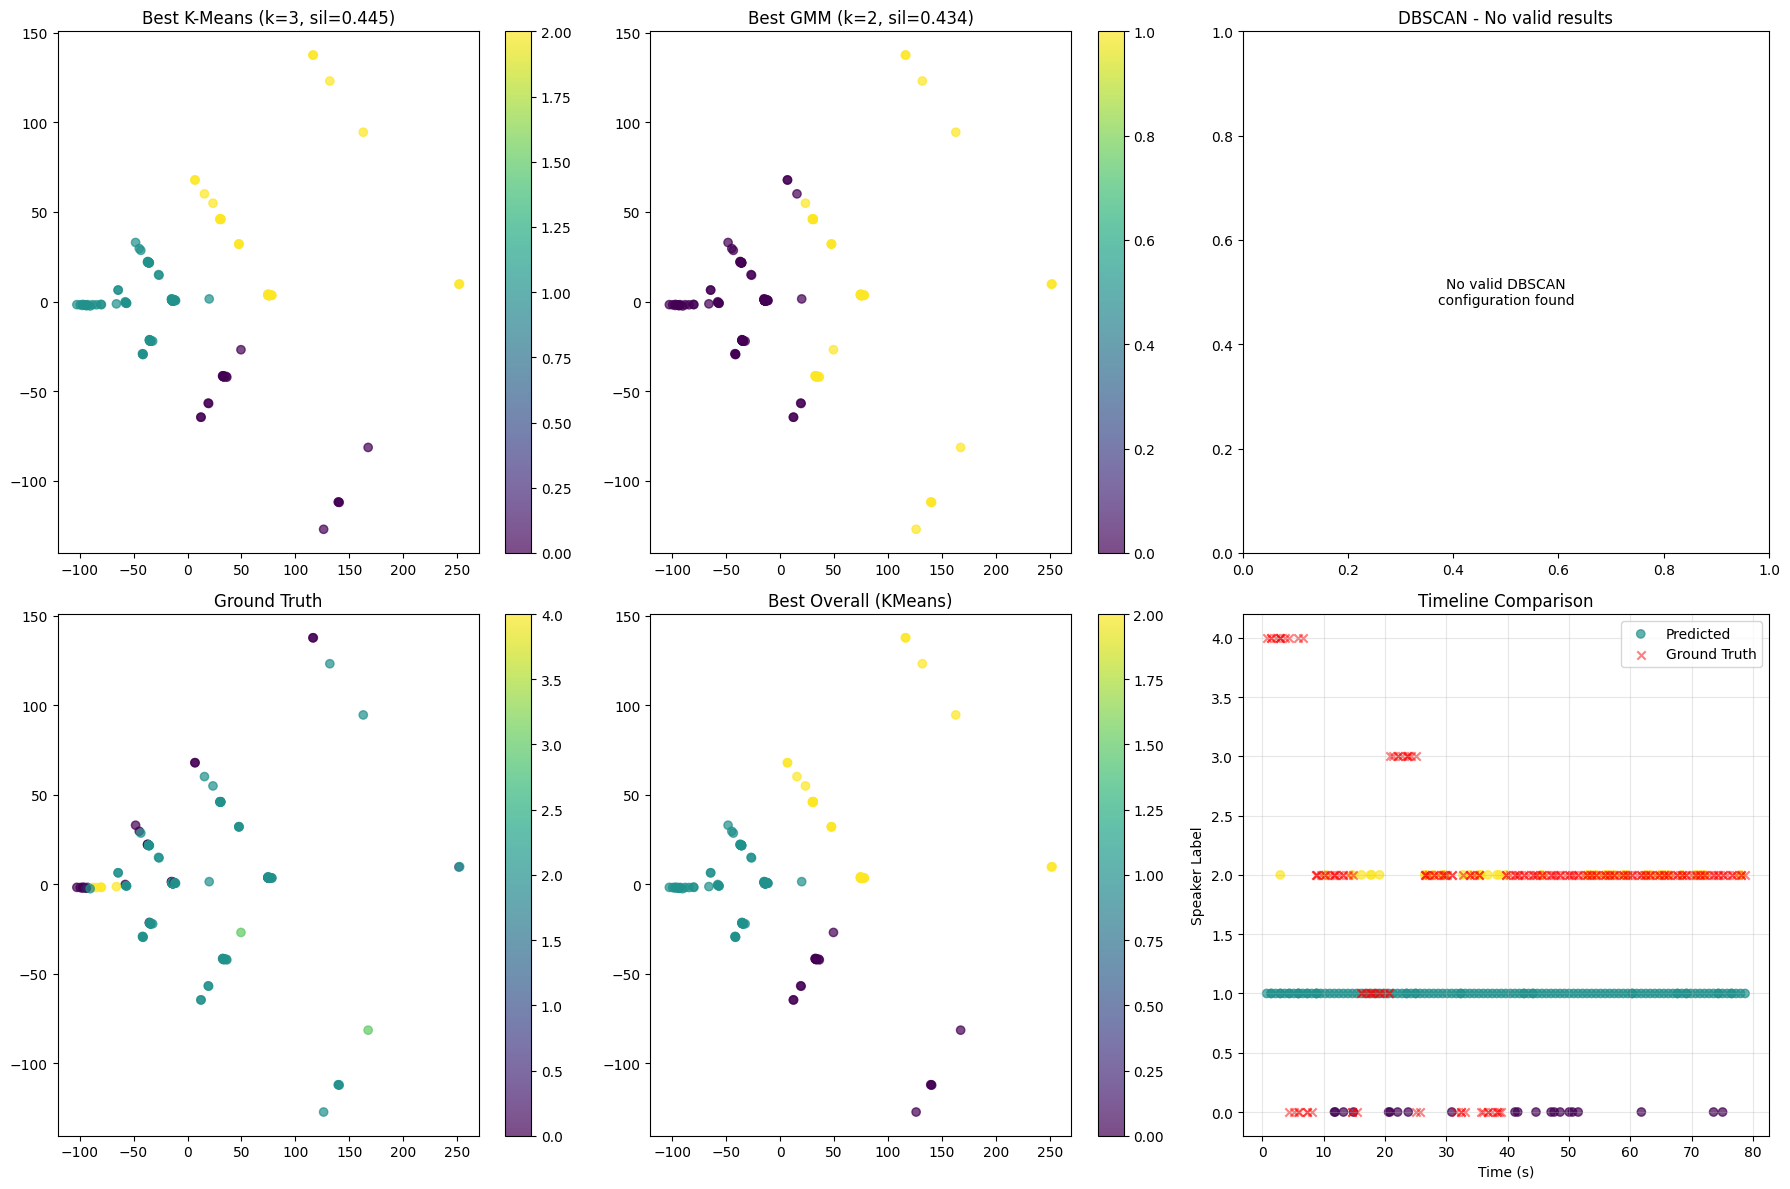


📊 ENHANCED STEP 6: Comprehensive Evaluation
   Calculating comprehensive metrics...

❌ Pipeline failed with error: Cannot cast array data from dtype('float64') to dtype('int64') according to the rule 'safe'

📊 BENCHMARKING AGAINST BASELINES


Traceback (most recent call last):
  File "/tmp/ipykernel_36/839560099.py", line 1400, in run_complete_pipeline
    self.comprehensive_evaluation()
  File "/tmp/ipykernel_36/839560099.py", line 1076, in comprehensive_evaluation
    pred_counts = np.bincount(speaker_pred)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: Cannot cast array data from dtype('float64') to dtype('int64') according to the rule 'safe'


   Method Comparison:
   Simple K-Means      : ARI=-0.021, NMI=0.022, F1=0.243
   Simple K-Means      : Silhouette=0.419
   Simple GMM          : ARI=0.024, NMI=0.030, F1=0.281
   Simple GMM          : Silhouette=0.219
   Enhanced Pipeline   : ARI=-0.038, NMI=0.046, F1=0.266
   Enhanced Pipeline   : Silhouette=0.445

💾 Exporting results to diarization_results
   ✅ Results exported successfully
   Files: predictions.rttm, evaluation_metrics.json, best_model_configs.json, pipeline.pkl

🎉 All done! Check the visualizations and results above.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import soundfile as sf
from scipy.signal import find_peaks, butter, filtfilt
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, 
                           precision_score, recall_score, f1_score, adjusted_rand_score, 
                           normalized_mutual_info_score, silhouette_score)
from sklearn.model_selection import ParameterGrid
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

class EnhancedVoxConverseDiarizationPipeline:
    def __init__(self, dataset_path="/kaggle/input/voxconverse-dataset", sr=16000):
        """
        Enhanced VoxConverse diarization pipeline with improvements
        """
        self.dataset_path = dataset_path
        self.sr = sr
        self.audio = None
        self.duration = None
        self.features = None
        self.speaker_labels = None
        self.vad_segments = None
        self.dataset_mapping = []
        
    def understand_dataset_structure(self):
        """
        STEP 0: Understand and analyze the VoxConverse dataset structure
        """
        print("📁 STEP 0: Understanding VoxConverse Dataset Structure")
        print("=" * 60)
        
        # Define paths
        dev_audio_path = Path(self.dataset_path) / "voxconverse_dev_wav" / "audio"
        test_audio_path = Path(self.dataset_path) / "voxconverse_test_wav" / "voxconverse_test_wav"
        labels_path = Path(self.dataset_path) / "labels" / "dev"
        
        # Check if paths exist
        paths_info = {
            "Dev Audio": dev_audio_path,
            "Test Audio": test_audio_path,
            "Labels": labels_path
        }
        
        print("Checking dataset paths:")
        for name, path in paths_info.items():
            exists = path.exists()
            print(f"   {name}: {'✓' if exists else '✗'} {path}")
            if exists:
                files = list(path.glob("*.*"))
                print(f"      Files found: {len(files)}")
                if files:
                    print(f"      Sample: {files[0].name}")
        
        # List all files
        dev_audio_files = list(dev_audio_path.glob("*.wav")) if dev_audio_path.exists() else []
        test_audio_files = list(test_audio_path.glob("*.wav")) if test_audio_path.exists() else []
        label_files = list(labels_path.glob("*.rttm")) if labels_path.exists() else []
        
        print(f"\nDataset Statistics:")
        print(f"   Dev audio files: {len(dev_audio_files)}")
        print(f"   Test audio files: {len(test_audio_files)}")
        print(f"   Label files: {len(label_files)}")
        
        # Parse RTTM files and create dataset mapping
        def parse_rttm(rttm_file):
            """Parse RTTM file to extract speaker segments"""
            segments = []
            with open(rttm_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 8 and parts[0] == 'SPEAKER':
                        file_id = parts[1]
                        start_time = float(parts[3])
                        duration = float(parts[4])
                        speaker_id = parts[7]
                        segments.append({
                            'file_id': file_id,
                            'start_time': start_time,
                            'duration': duration,
                            'end_time': start_time + duration,
                            'speaker_id': speaker_id
                        })
            return segments
        
        # Create dataset mapping
        self.dataset_mapping = []
        for rttm_file in label_files:
            file_id = rttm_file.stem
            
            # Find corresponding audio file
            audio_file = None
            for audio_path in [dev_audio_path, test_audio_path]:
                potential_audio = audio_path / f"{file_id}.wav"
                if potential_audio.exists():
                    audio_file = str(potential_audio)
                    break
            
            if audio_file:
                segments = parse_rttm(rttm_file)
                self.dataset_mapping.append({
                    'file_id': file_id,
                    'audio_path': audio_file,
                    'rttm_path': str(rttm_file),
                    'segments': segments,
                    'num_speakers': len(set(seg['speaker_id'] for seg in segments))
                })
        
        print(f"\nDataset Mapping Created:")
        print(f"   Matched audio-label pairs: {len(self.dataset_mapping)}")
        
        if self.dataset_mapping:
            # Analyze dataset statistics
            speaker_counts = [data['num_speakers'] for data in self.dataset_mapping]
            total_segments = sum(len(data['segments']) for data in self.dataset_mapping)
            
            print(f"   Total speaker segments: {total_segments}")
            print(f"   Average speakers per recording: {np.mean(speaker_counts):.2f}")
            print(f"   Speaker count range: {min(speaker_counts)} - {max(speaker_counts)}")
        
        print("\n✅ Dataset structure analysis completed")
        return self
    
    def load_real_audio(self, file_index=0):
        """
        Load real audio from VoxConverse dataset
        """
        print(f"\n🎵 STEP 1: Loading Real Audio from VoxConverse Dataset")
        print("=" * 60)
        
        if not self.dataset_mapping:
            print("❌ No dataset mapping available. Run understand_dataset_structure() first.")
            return self.generate_synthetic_data()
        
        # Load specific file
        if file_index >= len(self.dataset_mapping):
            file_index = 0
        
        sample_data = self.dataset_mapping[file_index]
        print(f"Loading file: {sample_data['file_id']}")
        
        try:
            # Load audio
            self.audio, _ = librosa.load(sample_data['audio_path'], sr=self.sr)
            self.duration = len(self.audio) / self.sr
            
            # Create ground truth labels
            self.ground_truth = np.zeros(len(self.audio))
            self.time = np.arange(len(self.audio)) / self.sr
            
            # Map speakers to integer labels
            unique_speakers = sorted(set(seg['speaker_id'] for seg in sample_data['segments']))
            speaker_to_id = {speaker: idx + 1 for idx, speaker in enumerate(unique_speakers)}
            
            for segment in sample_data['segments']:
                start_sample = int(segment['start_time'] * self.sr)
                end_sample = int(segment['end_time'] * self.sr)
                speaker_id = speaker_to_id[segment['speaker_id']]
                
                # Ensure we don't go out of bounds
                start_sample = max(0, min(start_sample, len(self.audio) - 1))
                end_sample = max(0, min(end_sample, len(self.audio)))
                
                self.ground_truth[start_sample:end_sample] = speaker_id
            
            # Store metadata
            self.current_file = sample_data
            self.speaker_mapping = speaker_to_id
            
            print(f"✅ Loaded audio: {self.duration:.2f}s, {len(unique_speakers)} speakers")
            print(f"   Speakers: {list(unique_speakers)}")
            print(f"   Audio shape: {self.audio.shape}")
            
        except Exception as e:
            print(f"❌ Error loading real audio: {e}")
            print("Falling back to synthetic data...")
            return self.generate_synthetic_data()
        
        return self
    
    def generate_synthetic_data(self):
        """
        Generate synthetic multi-speaker audio data for demonstration
        """
        print("🎵 STEP 1: Generating Synthetic Multi-Speaker Audio Data")
        print("=" * 60)
        
        # Create synthetic audio with 3 speakers
        duration = 30  # seconds
        t = np.linspace(0, duration, duration * self.sr)
        
        # Speaker 1: Low frequency (male voice simulation)
        speaker1_times = [(0, 5), (10, 15), (20, 25)]
        # Speaker 2: Medium frequency (female voice simulation) 
        speaker2_times = [(3, 8), (13, 18), (23, 28)]
        # Speaker 3: High frequency (child voice simulation)
        speaker3_times = [(6, 11), (16, 21), (26, 30)]
        
        audio = np.zeros(len(t))
        ground_truth = np.zeros(len(t))
        
        # Generate speaker segments
        for start, end in speaker1_times:
            mask = (t >= start) & (t <= end)
            audio[mask] += 0.5 * (np.sin(2 * np.pi * 150 * t[mask]) + 
                                 0.3 * np.sin(2 * np.pi * 300 * t[mask]) + 
                                 0.2 * np.random.randn(np.sum(mask))) * np.exp(-0.1 * (t[mask] - start))
            ground_truth[mask] = 1
            
        for start, end in speaker2_times:
            mask = (t >= start) & (t <= end)
            audio[mask] += 0.4 * (np.sin(2 * np.pi * 250 * t[mask]) + 
                                 0.4 * np.sin(2 * np.pi * 500 * t[mask]) + 
                                 0.15 * np.random.randn(np.sum(mask))) * np.exp(-0.1 * (t[mask] - start))
            ground_truth[mask] = 2
            
        for start, end in speaker3_times:
            mask = (t >= start) & (t <= end)
            audio[mask] += 0.3 * (np.sin(2 * np.pi * 350 * t[mask]) + 
                                 0.5 * np.sin(2 * np.pi * 700 * t[mask]) + 
                                 0.1 * np.random.randn(np.sum(mask))) * np.exp(-0.1 * (t[mask] - start))
            ground_truth[mask] = 3
        
        # Add background noise
        audio += 0.05 * np.random.randn(len(t))
        audio = audio / np.max(np.abs(audio)) * 0.8
        
        self.audio = audio
        self.duration = duration
        self.ground_truth = ground_truth
        self.time = t
        
        print(f"✅ Generated {duration}s audio with 3 speakers")
        return self
    
    def enhanced_voice_activity_detection(self, energy_factor=2.0, spectral_factor=1.5):
        """
        ENHANCED STEP 2: Improved Voice Activity Detection with tunable parameters
        """
        print("\n🎙️ ENHANCED STEP 2: Advanced Voice Activity Detection")
        print("=" * 60)
        
        frame_length = int(0.025 * self.sr)  # 25ms frames
        hop_length = int(0.010 * self.sr)    # 10ms hop
        
        print("   Applying multi-method VAD with tuned thresholds...")
        
        # Method 1: Energy-based VAD with adaptive threshold
        energy = []
        times = []
        
        for i in range(0, len(self.audio) - frame_length, hop_length):
            frame = self.audio[i:i + frame_length]
            frame_energy = np.sum(frame ** 2)
            energy.append(frame_energy)
            times.append(i / self.sr)
        
        energy = np.array(energy)
        times = np.array(times)
        
        # More sensitive adaptive threshold for quiet speakers
        window_size = int(1.0 / (hop_length / self.sr))
        energy_mean = pd.Series(energy).rolling(window=window_size, center=True).mean().fillna(energy.mean())
        energy_std = pd.Series(energy).rolling(window=window_size, center=True).std().fillna(energy.std())
        
        # Reduced threshold factor to catch quiet speakers
        adaptive_threshold = energy_mean + energy_factor * energy_std
        energy_vad = energy > adaptive_threshold
        
        # Method 2: Enhanced spectral features VAD
        zcr = librosa.feature.zero_crossing_rate(self.audio, 
                                               frame_length=frame_length,
                                               hop_length=hop_length)[0]
        
        spectral_centroids = librosa.feature.spectral_centroid(y=self.audio, sr=self.sr,
                                                             hop_length=hop_length)[0]
        spectral_rolloff = librosa.feature.spectral_rolloff(y=self.audio, sr=self.sr,
                                                          hop_length=hop_length)[0]
        
        # More sensitive thresholds
        min_len = min(len(energy_vad), len(zcr), len(spectral_centroids), len(spectral_rolloff))
        energy_vad = energy_vad[:min_len]
        zcr = zcr[:min_len]
        spectral_centroids = spectral_centroids[:min_len]
        spectral_rolloff = spectral_rolloff[:min_len]
        times = times[:min_len]
        
        # Lowered thresholds to catch more speech
        zcr_threshold = np.percentile(zcr, 20)
        centroid_threshold = np.percentile(spectral_centroids, 15)
        rolloff_threshold = np.percentile(spectral_rolloff, 15)
        
        spectral_vad = (zcr > zcr_threshold) & (spectral_centroids > centroid_threshold) & (spectral_rolloff > rolloff_threshold)
        
        # Method 3: Enhanced band-pass filtering + RMS
        nyquist = self.sr // 2
        low_freq = 300 / nyquist
        high_freq = 3400 / nyquist
        b, a = butter(4, [low_freq, high_freq], btype='band')
        filtered_audio = filtfilt(b, a, self.audio)
        
        rms = librosa.feature.rms(y=filtered_audio, hop_length=hop_length)[0]
        rms = rms[:min_len]
        rms_threshold = np.percentile(rms, 20)  # Lowered threshold
        rms_vad = rms > rms_threshold
        
        # Method 4: Spectral flux for voice detection
        stft = librosa.stft(self.audio, hop_length=hop_length)
        magnitude = np.abs(stft)
        spectral_flux = np.sum(np.diff(magnitude, axis=1)**2, axis=0)
        spectral_flux = np.pad(spectral_flux, (1, 0), mode='constant')[:min_len]
        flux_threshold = np.percentile(spectral_flux, 25)
        flux_vad = spectral_flux > flux_threshold
        
        # Combine VAD methods with weighted voting
        vad_methods = np.stack([energy_vad, spectral_vad, rms_vad, flux_vad], axis=0)
        weights = np.array([0.3, 0.25, 0.25, 0.2])  # Weight energy less, others more equally
        combined_score = np.average(vad_methods.astype(float), weights=weights, axis=0)
        combined_vad = combined_score >= 0.4  # Lower threshold for sensitivity
        
        # Post-processing with shorter minimum durations
        combined_vad = self.post_process_vad(combined_vad, min_speech_duration=0.05, 
                                           min_silence_duration=0.03, hop_length=hop_length)
        
        # Store VAD results
        self.vad_times = times
        self.vad_energy = energy[:min_len]
        self.vad_voice_activity = combined_vad
        self.vad_methods = {
            'energy': energy_vad,
            'spectral': spectral_vad,
            'rms': rms_vad,
            'flux': flux_vad,
            'combined': combined_vad
        }
        
        # Enhanced visualization
        fig, axes = plt.subplots(3, 2, figsize=(16, 12))
        
        # Original audio
        axes[0, 0].plot(self.time, self.audio, 'b-', alpha=0.7, linewidth=0.5)
        axes[0, 0].set_title('Original Audio Signal')
        axes[0, 0].set_ylabel('Amplitude')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Energy-based VAD
        axes[0, 1].plot(times, energy[:min_len], 'g-', linewidth=1, label='Energy')
        axes[0, 1].plot(times, adaptive_threshold[:min_len], 'r--', linewidth=2, label='Adaptive Threshold')
        axes[0, 1].fill_between(times, 0, np.max(energy[:min_len]), where=energy_vad, alpha=0.3, color='yellow')
        axes[0, 1].set_title('Energy-based VAD (Tuned)')
        axes[0, 1].set_ylabel('Energy')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Spectral features
        axes[1, 0].plot(times, zcr, 'm-', linewidth=1, label='Zero Crossing Rate')
        axes[1, 0].axhline(y=zcr_threshold, color='orange', linestyle='--', label='ZCR Threshold')
        axes[1, 0].set_title('Zero Crossing Rate (Lowered Threshold)')
        axes[1, 0].set_ylabel('ZCR')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        axes[1, 1].plot(times, spectral_flux, 'purple', linewidth=1, label='Spectral Flux')
        axes[1, 1].axhline(y=flux_threshold, color='red', linestyle='--', label='Flux Threshold')
        axes[1, 1].fill_between(times, 0, np.max(spectral_flux), where=flux_vad, alpha=0.3, color='lightblue')
        axes[1, 1].set_title('Spectral Flux VAD')
        axes[1, 1].set_ylabel('Flux')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        # RMS and final VAD
        axes[2, 0].plot(times, rms, 'orange', linewidth=1, label='RMS (Filtered)')
        axes[2, 0].axhline(y=rms_threshold, color='red', linestyle='--', label='RMS Threshold')
        axes[2, 0].fill_between(times, 0, np.max(rms), where=rms_vad, alpha=0.3, color='lightgreen')
        axes[2, 0].set_title('RMS-based VAD (Lowered Threshold)')
        axes[2, 0].set_xlabel('Time (s)')
        axes[2, 0].set_ylabel('RMS')
        axes[2, 0].legend()
        axes[2, 0].grid(True, alpha=0.3)
        
        # Combined VAD result
        axes[2, 1].plot(self.time, self.audio, 'b-', alpha=0.3, linewidth=0.5, label='Audio')
        axes[2, 1].fill_between(times, -1, 1, where=combined_vad, alpha=0.7, color='red', label='Voice Activity')
        axes[2, 1].set_title('Enhanced Combined VAD Result')
        axes[2, 1].set_xlabel('Time (s)')
        axes[2, 1].set_ylabel('Amplitude')
        axes[2, 1].legend()
        axes[2, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Calculate VAD statistics
        voice_percentage = np.sum(combined_vad) / len(combined_vad) * 100
        individual_percentages = {method: np.sum(vad) / len(vad) * 100 
                                for method, vad in self.vad_methods.items() if method != 'combined'}
        
        print(f"✅ Enhanced VAD completed:")
        print(f"   Combined voice activity: {voice_percentage:.1f}% of audio (target: 15-25%)")
        for method, percentage in individual_percentages.items():
            print(f"   {method.capitalize()} method: {percentage:.1f}%")
        
        return self
    
    def post_process_vad(self, vad, min_speech_duration=0.05, min_silence_duration=0.03, hop_length=512):
        """
        Post-process VAD to remove short segments and fill short gaps
        """
        frame_duration = hop_length / self.sr
        min_speech_frames = int(min_speech_duration / frame_duration)
        min_silence_frames = int(min_silence_duration / frame_duration)
        
        # Remove short speech segments
        speech_segments = []
        start = None
        
        for i, is_speech in enumerate(vad):
            if is_speech and start is None:
                start = i
            elif not is_speech and start is not None:
                if i - start >= min_speech_frames:
                    speech_segments.append((start, i))
                start = None
        
        if start is not None and len(vad) - start >= min_speech_frames:
            speech_segments.append((start, len(vad)))
        
        # Create new VAD array
        new_vad = np.zeros_like(vad, dtype=bool)
        for start, end in speech_segments:
            new_vad[start:end] = True
        
        # Fill short silence gaps
        silence_segments = []
        start = None
        
        for i, is_silence in enumerate(~new_vad):
            if is_silence and start is None:
                start = i
            elif not is_silence and start is not None:
                if i - start <= min_silence_frames:
                    new_vad[start:i] = True
                start = None
        
        return new_vad
    
    def extract_enhanced_features(self):
        """
        ENHANCED STEP 3: Extract comprehensive audio features with delta coefficients
        """
        print("\n🔍 ENHANCED STEP 3: Advanced Audio Feature Extraction")
        print("=" * 60)
        
        frame_length = 2048
        hop_length = 512
        n_mels = 80  # Increased from 40
        n_mfcc = 20  # Increased from 13
        
        print("   Extracting comprehensive feature set...")
        
        # Basic spectral features
        stft = librosa.stft(self.audio, n_fft=frame_length, hop_length=hop_length)
        magnitude = np.abs(stft)
        
        # Mel-spectrogram and MFCCs with higher overlap
        mel_spec = librosa.feature.melspectrogram(y=self.audio, sr=self.sr, 
                                                n_mels=n_mels, hop_length=hop_length)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        mfccs = librosa.feature.mfcc(y=self.audio, sr=self.sr, n_mfcc=n_mfcc,
                                   hop_length=hop_length)
        
        # Delta and delta-delta features for temporal dynamics
        mfcc_delta = librosa.feature.delta(mfccs)
        mfcc_delta2 = librosa.feature.delta(mfccs, order=2)
        
        # Extended spectral features
        zcr = librosa.feature.zero_crossing_rate(self.audio, hop_length=hop_length)
        rms = librosa.feature.rms(y=self.audio, hop_length=hop_length)
        chroma = librosa.feature.chroma_stft(S=magnitude, sr=self.sr)
        spectral_centroids = librosa.feature.spectral_centroid(y=self.audio, sr=self.sr,
                                                             hop_length=hop_length)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=self.audio, sr=self.sr,
                                                          hop_length=hop_length)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=self.audio, sr=self.sr,
                                                              hop_length=hop_length)
        spectral_contrast = librosa.feature.spectral_contrast(y=self.audio, sr=self.sr,
                                                            hop_length=hop_length)
        
        # Tonnetz (harmonic features)
        tonnetz = librosa.feature.tonnetz(y=self.audio, sr=self.sr)
        
        # Tempogram for rhythm analysis
        tempogram = librosa.feature.tempogram(y=self.audio, sr=self.sr, hop_length=hop_length)
        
        self.features = {
            'stft': stft,
            'magnitude': magnitude,
            'mel_spec': mel_spec,
            'mel_spec_db': mel_spec_db,
            'mfccs': mfccs,
            'mfcc_delta': mfcc_delta,
            'mfcc_delta2': mfcc_delta2,
            'zcr': zcr,
            'rms': rms,
            'chroma': chroma,
            'spectral_centroids': spectral_centroids,
            'spectral_rolloff': spectral_rolloff,
            'spectral_bandwidth': spectral_bandwidth,
            'spectral_contrast': spectral_contrast,
            'tonnetz': tonnetz,
            'tempogram': tempogram
        }
        
        self.feature_times = librosa.frames_to_time(np.arange(mfccs.shape[1]), 
                                                   sr=self.sr, hop_length=hop_length)
        
        # Enhanced visualization
        fig = plt.figure(figsize=(18, 14))
        
        plt.subplot(4, 4, 1)
        librosa.display.specshow(mel_spec_db, sr=self.sr, hop_length=hop_length,
                               x_axis='time', y_axis='mel')
        plt.colorbar()
        plt.title('Mel-Spectrogram (dB)')
        
        plt.subplot(4, 4, 2)
        librosa.display.specshow(mfccs, sr=self.sr, hop_length=hop_length, x_axis='time')
        plt.colorbar()
        plt.title('MFCCs (20 coefficients)')
        plt.ylabel('MFCC Coefficients')
        
        plt.subplot(4, 4, 3)
        librosa.display.specshow(mfcc_delta, sr=self.sr, hop_length=hop_length, x_axis='time')
        plt.colorbar()
        plt.title('Delta MFCCs')
        plt.ylabel('Delta MFCC')
        
        plt.subplot(4, 4, 4)
        librosa.display.specshow(mfcc_delta2, sr=self.sr, hop_length=hop_length, x_axis='time')
        plt.colorbar()
        plt.title('Delta-Delta MFCCs')
        plt.ylabel('Delta-Delta MFCC')
        
        plt.subplot(4, 4, 5)
        librosa.display.specshow(chroma, sr=self.sr, hop_length=hop_length,
                               x_axis='time', y_axis='chroma')
        plt.colorbar()
        plt.title('Chroma Features')
        
        plt.subplot(4, 4, 6)
        librosa.display.specshow(spectral_contrast, sr=self.sr, hop_length=hop_length,
                               x_axis='time')
        plt.colorbar()
        plt.title('Spectral Contrast')
        
        plt.subplot(4, 4, 7)
        librosa.display.specshow(tonnetz, sr=self.sr, hop_length=hop_length, x_axis='time')
        plt.colorbar()
        plt.title('Tonnetz (Harmonic)')
        
        plt.subplot(4, 4, 8)
        plt.plot(self.feature_times, zcr[0], 'g-', linewidth=1)
        plt.title('Zero Crossing Rate')
        plt.xlabel('Time (s)')
        plt.ylabel('ZCR')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(4, 4, 9)
        plt.plot(self.feature_times, rms[0], 'r-', linewidth=1)
        plt.title('RMS Energy')
        plt.xlabel('Time (s)')
        plt.ylabel('RMS')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(4, 4, 10)
        plt.plot(self.feature_times, spectral_centroids[0], 'b-', linewidth=1)
        plt.title('Spectral Centroid')
        plt.xlabel('Time (s)')
        plt.ylabel('Hz')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(4, 4, 11)
        plt.plot(self.feature_times, spectral_rolloff[0], 'purple', linewidth=1)
        plt.title('Spectral Rolloff')
        plt.xlabel('Time (s)')
        plt.ylabel('Hz')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(4, 4, 12)
        plt.plot(self.feature_times, spectral_bandwidth[0], 'orange', linewidth=1)
        plt.title('Spectral Bandwidth')
        plt.xlabel('Time (s)')
        plt.ylabel('Hz')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"✅ Enhanced feature extraction completed")
        print(f"   MFCCs shape: {mfccs.shape}")
        print(f"   Delta MFCCs shape: {mfcc_delta.shape}")
        print(f"   Total features: MFCCs({n_mfcc}) + Delta({n_mfcc}) + Delta2({n_mfcc}) + Others")
        print(f"   Feature time frames: {len(self.feature_times)}")
        
        return self
    
    def create_enhanced_embeddings(self, window_sizes=[1.5, 3.0, 6.0], overlap=0.5):
        """
        ENHANCED STEP 4: Create multi-scale speaker embeddings with statistical features
        """
        print("\n🎯 ENHANCED STEP 4: Multi-Scale Speaker Embeddings")
        print("=" * 60)
        
        # Combine all features into a comprehensive feature matrix
        feature_list = []
        feature_names = []
        
        # MFCCs and deltas
        feature_list.extend([self.features['mfccs'], self.features['mfcc_delta'], self.features['mfcc_delta2']])
        feature_names.extend(['MFCC', 'Delta_MFCC', 'Delta2_MFCC'])
        
        # Spectral features
        feature_list.extend([
            self.features['zcr'], self.features['rms'], 
            self.features['spectral_centroids'], self.features['spectral_rolloff'],
            self.features['spectral_bandwidth'], self.features['spectral_contrast'],
            self.features['chroma'], self.features['tonnetz']
        ])
        feature_names.extend([
            'ZCR', 'RMS', 'Spectral_Centroid', 'Spectral_Rolloff',
            'Spectral_Bandwidth', 'Spectral_Contrast', 'Chroma', 'Tonnetz'
        ])
        
        # Combine features
        combined_features = np.vstack(feature_list)
        print(f"   Combined feature matrix shape: {combined_features.shape}")
        
        # Multi-scale windowing
        embeddings = []
        embedding_times = []
        embedding_labels = []
        
        for window_size in window_sizes:
            print(f"   Processing {window_size}s windows...")
            
            window_frames = int(window_size * self.sr / 512)  # 512 is hop_length
            step_frames = int(window_frames * (1 - overlap))
            
            for start_frame in range(0, combined_features.shape[1] - window_frames, step_frames):
                end_frame = start_frame + window_frames
                
                # Extract window
                window_features = combined_features[:, start_frame:end_frame]
                
                # Calculate comprehensive statistical features
                stats = self.calculate_statistical_features(window_features)
                
                # Time information
                start_time = self.feature_times[start_frame]
                end_time = self.feature_times[min(end_frame-1, len(self.feature_times)-1)]
                center_time = (start_time + end_time) / 2
                
                # Get ground truth label for this window (if available)
                if hasattr(self, 'ground_truth'):
                    start_sample = int(start_time * self.sr)
                    end_sample = int(end_time * self.sr)
                    window_labels = self.ground_truth[start_sample:end_sample]
                    # Use the most common label in the window
                    if len(window_labels) > 0:
                        unique_labels, counts = np.unique(window_labels, return_counts=True)
                        most_common_label = unique_labels[np.argmax(counts)]
                    else:
                        most_common_label = 0
                else:
                    most_common_label = 0
                
                embeddings.append(stats)
                embedding_times.append(center_time)
                embedding_labels.append(most_common_label)
        
        self.embeddings = np.array(embeddings)
        self.embedding_times = np.array(embedding_times)
        self.embedding_labels = np.array(embedding_labels)
        
        # Apply robust normalization
        scaler = RobustScaler()
        self.embeddings_normalized = scaler.fit_transform(self.embeddings)
        self.scaler = scaler
        
        print(f"✅ Multi-scale embeddings created:")
        print(f"   Total embeddings: {len(self.embeddings)}")
        print(f"   Embedding dimension: {self.embeddings.shape[1]}")
        print(f"   Window sizes used: {window_sizes}")
        print(f"   Normalization: RobustScaler")
        
        # Visualization
        self.visualize_embeddings()
        
        return self
    
    def calculate_statistical_features(self, features):
        """
        Calculate comprehensive statistical features for a feature matrix
        """
        stats = []
        
        for feature_row in features:
            # Basic statistics
            stats.extend([
                np.mean(feature_row),      # Mean
                np.std(feature_row),       # Standard deviation  
                np.min(feature_row),       # Minimum
                np.max(feature_row),       # Maximum
                np.median(feature_row),    # Median
                np.percentile(feature_row, 25),  # 25th percentile
                np.percentile(feature_row, 75),  # 75th percentile
                np.ptp(feature_row),       # Range (peak-to-peak)
                np.mean(np.abs(np.diff(feature_row))),  # Mean absolute difference
                np.std(np.diff(feature_row)),           # Std of differences
                len(feature_row) / (1 + np.sum(np.abs(np.diff(feature_row)) < 0.01))  # Stability measure
            ])
        
        return np.array(stats)
    
    def visualize_embeddings(self):
        """
        Visualize embeddings using PCA and t-SNE
        """
        print("   Creating embedding visualizations...")
        
        # PCA
        pca = PCA(n_components=2)
        embeddings_pca = pca.fit_transform(self.embeddings_normalized)
        
        # t-SNE
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(self.embeddings_normalized)-1))
        embeddings_tsne = tsne.fit_transform(self.embeddings_normalized)
        
        # Create visualization
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # PCA plot
        scatter = axes[0, 0].scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], 
                                   c=self.embedding_labels, cmap='viridis', alpha=0.7)
        axes[0, 0].set_title(f'PCA Visualization (Explained Variance: {pca.explained_variance_ratio_.sum():.3f})')
        axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
        axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')
        plt.colorbar(scatter, ax=axes[0, 0])
        
        # t-SNE plot
        scatter2 = axes[0, 1].scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], 
                                    c=self.embedding_labels, cmap='viridis', alpha=0.7)
        axes[0, 1].set_title('t-SNE Visualization')
        axes[0, 1].set_xlabel('t-SNE 1')
        axes[0, 1].set_ylabel('t-SNE 2')
        plt.colorbar(scatter2, ax=axes[0, 1])
        
        # Feature importance (PCA loadings)
        n_features = min(20, len(pca.components_[0]))
        feature_importance = np.abs(pca.components_[0][:n_features])
        axes[1, 0].barh(range(n_features), feature_importance)
        axes[1, 0].set_title('Feature Importance (PC1 Loadings)')
        axes[1, 0].set_xlabel('Absolute Loading')
        axes[1, 0].set_ylabel('Feature Index')
        
        # Embedding timeline
        axes[1, 1].scatter(self.embedding_times, self.embedding_labels, 
                         c=self.embedding_labels, cmap='viridis', alpha=0.7)
        axes[1, 1].set_title('Embedding Timeline')
        axes[1, 1].set_xlabel('Time (s)')
        axes[1, 1].set_ylabel('Speaker Label')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Store visualization results
        self.pca = pca
        self.embeddings_pca = embeddings_pca
        self.embeddings_tsne = embeddings_tsne
    
    def optimized_clustering(self, k_range=(2, 8)):
        """
        ENHANCED STEP 5: Optimized clustering with hyperparameter tuning
        """
        print("\n🔬 ENHANCED STEP 5: Optimized Clustering with Hyperparameter Tuning")
        print("=" * 60)
        
        X = self.embeddings_normalized
        
        # Extended K-range testing
        k_min, k_max = k_range
        k_values = list(range(k_min, k_max + 1))
        
        clustering_results = {}
        
        print("   Testing K-Means with multiple configurations...")
        # K-Means with multiple initialization methods
        kmeans_results = {}
        for k in k_values:
            for init in ['k-means++', 'random']:
                for n_init in [10, 20]:
                    key = f"kmeans_k{k}_init{init}_ninit{n_init}"
                    kmeans = KMeans(n_clusters=k, init=init, n_init=n_init, random_state=42)
                    labels = kmeans.fit_predict(X)
                    
                    # Calculate silhouette score
                    if len(np.unique(labels)) > 1:
                        sil_score = silhouette_score(X, labels)
                        inertia = kmeans.inertia_
                    else:
                        sil_score = -1
                        inertia = float('inf')
                    
                    kmeans_results[key] = {
                        'model': kmeans,
                        'labels': labels,
                        'silhouette_score': sil_score,
                        'inertia': inertia,
                        'k': k,
                        'init': init,
                        'n_init': n_init
                    }
        
        print("   Testing Gaussian Mixture Models...")
        # Gaussian Mixture Models
        gmm_results = {}
        for k in k_values:
            for covariance_type in ['full', 'tied', 'diag']:
                try:
                    key = f"gmm_k{k}_cov{covariance_type}"
                    gmm = GaussianMixture(n_components=k, covariance_type=covariance_type, random_state=42)
                    labels = gmm.fit_predict(X)
                    
                    if len(np.unique(labels)) > 1:
                        sil_score = silhouette_score(X, labels)
                        aic = gmm.aic(X)
                        bic = gmm.bic(X)
                    else:
                        sil_score = -1
                        aic = float('inf')
                        bic = float('inf')
                    
                    gmm_results[key] = {
                        'model': gmm,
                        'labels': labels,
                        'silhouette_score': sil_score,
                        'aic': aic,
                        'bic': bic,
                        'k': k,
                        'covariance_type': covariance_type
                    }
                except Exception as e:
                    print(f"   Warning: GMM with k={k}, cov={covariance_type} failed: {e}")
        
        print("   Testing DBSCAN with parameter optimization...")
        # DBSCAN with parameter optimization
        dbscan_results = {}
        eps_values = np.linspace(0.1, 2.0, 10)
        min_samples_values = [2, 3, 5, 8, 10]
        
        for eps in eps_values:
            for min_samples in min_samples_values:
                key = f"dbscan_eps{eps:.2f}_min{min_samples}"
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                labels = dbscan.fit_predict(X)
                
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                
                if n_clusters > 1 and n_clusters < len(X):
                    # Remove noise points for silhouette calculation
                    mask = labels != -1
                    if np.sum(mask) > 1:
                        sil_score = silhouette_score(X[mask], labels[mask])
                        noise_ratio = np.sum(labels == -1) / len(labels)
                    else:
                        sil_score = -1
                        noise_ratio = 1.0
                else:
                    sil_score = -1
                    noise_ratio = np.sum(labels == -1) / len(labels) if len(labels) > 0 else 1.0
                
                dbscan_results[key] = {
                    'model': dbscan,
                    'labels': labels,
                    'silhouette_score': sil_score,
                    'n_clusters': n_clusters,
                    'noise_ratio': noise_ratio,
                    'eps': eps,
                    'min_samples': min_samples
                }
        
        # Combine all results
        clustering_results.update(kmeans_results)
        clustering_results.update(gmm_results)
        clustering_results.update(dbscan_results)
        
        # Find best models
        print("\n   Selecting best models...")
        
        # Best K-Means
        best_kmeans = max(kmeans_results.values(), key=lambda x: x['silhouette_score'])
        
        # Best GMM
        best_gmm = max(gmm_results.values(), key=lambda x: x['silhouette_score'])
        
        # Best DBSCAN
        valid_dbscan = {k: v for k, v in dbscan_results.items() if v['silhouette_score'] > 0}
        if valid_dbscan:
            best_dbscan = max(valid_dbscan.values(), key=lambda x: x['silhouette_score'])
        else:
            best_dbscan = None
        
        # Overall best model
        candidates = [best_kmeans, best_gmm]
        if best_dbscan is not None:
            candidates.append(best_dbscan)
        
        best_overall = max(candidates, key=lambda x: x['silhouette_score'])
        
        # Store results
        self.clustering_results = clustering_results
        self.best_models = {
            'kmeans': best_kmeans,
            'gmm': best_gmm,
            'dbscan': best_dbscan,
            'overall': best_overall
        }
        self.predicted_labels = best_overall['labels']
        
        # Report results
        print(f"\n✅ Clustering optimization completed:")
        print(f"   Total configurations tested: {len(clustering_results)}")
        print(f"   Best K-Means: k={best_kmeans['k']}, silhouette={best_kmeans['silhouette_score']:.3f}")
        print(f"   Best GMM: k={best_gmm['k']}, silhouette={best_gmm['silhouette_score']:.3f}")
        if best_dbscan:
            print(f"   Best DBSCAN: clusters={best_dbscan['n_clusters']}, silhouette={best_dbscan['silhouette_score']:.3f}")
        print(f"   Overall best: {type(best_overall['model']).__name__}, silhouette={best_overall['silhouette_score']:.3f}")
        
        # Visualize results
        self.visualize_clustering_results()
        
        return self
    
    def visualize_clustering_results(self):
        """
        Visualize clustering results
        """
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Best K-Means
        kmeans_labels = self.best_models['kmeans']['labels']
        scatter1 = axes[0, 0].scatter(self.embeddings_pca[:, 0], self.embeddings_pca[:, 1], 
                                    c=kmeans_labels, cmap='viridis', alpha=0.7)
        axes[0, 0].set_title(f"Best K-Means (k={self.best_models['kmeans']['k']}, sil={self.best_models['kmeans']['silhouette_score']:.3f})")
        plt.colorbar(scatter1, ax=axes[0, 0])
        
        # Best GMM
        gmm_labels = self.best_models['gmm']['labels']
        scatter2 = axes[0, 1].scatter(self.embeddings_pca[:, 0], self.embeddings_pca[:, 1], 
                                    c=gmm_labels, cmap='viridis', alpha=0.7)
        axes[0, 1].set_title(f"Best GMM (k={self.best_models['gmm']['k']}, sil={self.best_models['gmm']['silhouette_score']:.3f})")
        plt.colorbar(scatter2, ax=axes[0, 1])
        
        # Best DBSCAN
        if self.best_models['dbscan'] is not None:
            dbscan_labels = self.best_models['dbscan']['labels']
            scatter3 = axes[0, 2].scatter(self.embeddings_pca[:, 0], self.embeddings_pca[:, 1], 
                                        c=dbscan_labels, cmap='viridis', alpha=0.7)
            axes[0, 2].set_title(f"Best DBSCAN (clusters={self.best_models['dbscan']['n_clusters']}, sil={self.best_models['dbscan']['silhouette_score']:.3f})")
            plt.colorbar(scatter3, ax=axes[0, 2])
        else:
            axes[0, 2].text(0.5, 0.5, 'No valid DBSCAN\nconfiguration found', 
                          ha='center', va='center', transform=axes[0, 2].transAxes)
            axes[0, 2].set_title('DBSCAN - No valid results')
        
        # Ground truth (if available)
        if hasattr(self, 'embedding_labels'):
            scatter4 = axes[1, 0].scatter(self.embeddings_pca[:, 0], self.embeddings_pca[:, 1], 
                                        c=self.embedding_labels, cmap='viridis', alpha=0.7)
            axes[1, 0].set_title('Ground Truth')
            plt.colorbar(scatter4, ax=axes[1, 0])
        
        # Best overall
        best_labels = self.predicted_labels
        scatter5 = axes[1, 1].scatter(self.embeddings_pca[:, 0], self.embeddings_pca[:, 1], 
                                    c=best_labels, cmap='viridis', alpha=0.7)
        axes[1, 1].set_title(f"Best Overall ({type(self.best_models['overall']['model']).__name__})")
        plt.colorbar(scatter5, ax=axes[1, 1])
        
        # Timeline comparison
        axes[1, 2].scatter(self.embedding_times, self.predicted_labels, 
                         c=self.predicted_labels, cmap='viridis', alpha=0.7, label='Predicted')
        if hasattr(self, 'embedding_labels'):
            axes[1, 2].scatter(self.embedding_times, self.embedding_labels, 
                             c='red', marker='x', alpha=0.5, label='Ground Truth')
            axes[1, 2].legend()
        axes[1, 2].set_title('Timeline Comparison')
        axes[1, 2].set_xlabel('Time (s)')
        axes[1, 2].set_ylabel('Speaker Label')
        axes[1, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def comprehensive_evaluation(self):
        """
        ENHANCED STEP 6: Comprehensive evaluation with multiple metrics
        """
        print("\n📊 ENHANCED STEP 6: Comprehensive Evaluation")
        print("=" * 60)
        
        if not hasattr(self, 'embedding_labels'):
            print("❌ No ground truth labels available for evaluation")
            return self
        
        y_true = self.embedding_labels
        y_pred = self.predicted_labels
        
        # Remove silence frames (label 0) for evaluation
        mask = y_true != 0
        y_true_speech = y_true[mask]
        y_pred_speech = y_pred[mask]
        
        if len(y_true_speech) == 0:
            print("❌ No speech segments found for evaluation")
            return self
        
        print("   Calculating comprehensive metrics...")
        
        # Enhanced label alignment using IoU-based Hungarian algorithm
        aligned_pred = self.align_labels_iou(y_true_speech, y_pred_speech)
        
        # Basic clustering metrics
        ari = adjusted_rand_score(y_true_speech, aligned_pred)
        nmi = normalized_mutual_info_score(y_true_speech, aligned_pred)
        
        # Classification metrics (macro and weighted)
        accuracy = accuracy_score(y_true_speech, aligned_pred)
        precision_macro = precision_score(y_true_speech, aligned_pred, average='macro', zero_division=0)
        recall_macro = recall_score(y_true_speech, aligned_pred, average='macro', zero_division=0)
        f1_macro = f1_score(y_true_speech, aligned_pred, average='macro', zero_division=0)
        
        precision_weighted = precision_score(y_true_speech, aligned_pred, average='weighted', zero_division=0)
        recall_weighted = recall_score(y_true_speech, aligned_pred, average='weighted', zero_division=0)
        f1_weighted = f1_score(y_true_speech, aligned_pred, average='weighted', zero_division=0)
        
        # Per-speaker analysis
        unique_speakers = np.unique(y_true_speech)
        per_speaker_metrics = {}
        
        for speaker in unique_speakers:
            speaker_mask = y_true_speech == speaker
            if np.sum(speaker_mask) > 0:
                speaker_pred = aligned_pred[speaker_mask]
                speaker_true = y_true_speech[speaker_mask]
                
                # Find the most assigned cluster for this speaker
                pred_counts = np.bincount(speaker_pred)
                most_common_pred = np.argmax(pred_counts) if len(pred_counts) > 0 else 0
                
                # Calculate metrics for this speaker
                speaker_precision = np.sum(speaker_pred == most_common_pred) / len(speaker_pred)
                speaker_recall = np.sum(aligned_pred == most_common_pred) / np.sum(y_true_speech == speaker) if np.sum(y_true_speech == speaker) > 0 else 0
                speaker_f1 = 2 * speaker_precision * speaker_recall / (speaker_precision + speaker_recall) if (speaker_precision + speaker_recall) > 0 else 0
                
                per_speaker_metrics[f'Speaker_{int(speaker)}'] = {
                    'precision': speaker_precision,
                    'recall': speaker_recall,
                    'f1': speaker_f1,
                    'samples': np.sum(speaker_mask)
                }
        
        # Purity and Coverage (segment-level)
        purity = self.calculate_purity(y_true_speech, aligned_pred)
        coverage = self.calculate_coverage(y_true_speech, aligned_pred)
        
        # Store evaluation results
        self.evaluation_results = {
            'accuracy': accuracy,
            'adjusted_rand_index': ari,
            'normalized_mutual_info': nmi,
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'f1_macro': f1_macro,
            'precision_weighted': precision_weighted,
            'recall_weighted': recall_weighted,
            'f1_weighted': f1_weighted,
            'purity': purity,
            'coverage': coverage,
            'per_speaker': per_speaker_metrics,
            'aligned_predictions': aligned_pred,
            'confusion_matrix': confusion_matrix(y_true_speech, aligned_pred)
        }
        
        # Report results
        print(f"\n✅ Comprehensive evaluation completed:")
        print(f"   Accuracy: {accuracy:.3f}")
        print(f"   Adjusted Rand Index: {ari:.3f}")
        print(f"   Normalized Mutual Info: {nmi:.3f}")
        print(f"   F1-Score (Macro): {f1_macro:.3f}")
        print(f"   F1-Score (Weighted): {f1_weighted:.3f}")
        print(f"   Purity: {purity:.3f}")
        print(f"   Coverage: {coverage:.3f}")
        
        print(f"\n   Per-Speaker Performance:")
        for speaker, metrics in per_speaker_metrics.items():
            print(f"   {speaker}: F1={metrics['f1']:.3f}, Precision={metrics['precision']:.3f}, Recall={metrics['recall']:.3f} ({metrics['samples']} samples)")
        
        # Advanced visualizations
        self.create_evaluation_visualizations()
        
        return self
    
    def align_labels_iou(self, y_true, y_pred):
        """
        Enhanced label alignment using IoU-based Hungarian algorithm
        """
        true_labels = np.unique(y_true)
        pred_labels = np.unique(y_pred)
        
        # Calculate IoU matrix
        iou_matrix = np.zeros((len(true_labels), len(pred_labels)))
        
        for i, true_label in enumerate(true_labels):
            for j, pred_label in enumerate(pred_labels):
                true_mask = y_true == true_label
                pred_mask = y_pred == pred_label
                
                intersection = np.sum(true_mask & pred_mask)
                union = np.sum(true_mask | pred_mask)
                
                iou_matrix[i, j] = intersection / union if union > 0 else 0
        
        # Use Hungarian algorithm for optimal assignment
        cost_matrix = 1 - iou_matrix  # Convert to cost matrix
        row_indices, col_indices = linear_sum_assignment(cost_matrix)
        
        # Create label mapping
        label_mapping = {}
        for i, j in zip(row_indices, col_indices):
            label_mapping[pred_labels[j]] = true_labels[i]
        
        # Apply mapping
        aligned_pred = np.array([label_mapping.get(label, label) for label in y_pred])
        
        return aligned_pred
    
    def calculate_purity(self, y_true, y_pred):
        """
        Calculate clustering purity
        """
        total = len(y_true)
        cluster_labels = np.unique(y_pred)
        purity = 0
        
        for cluster in cluster_labels:
            cluster_mask = y_pred == cluster
            if np.sum(cluster_mask) > 0:
                true_labels_in_cluster = y_true[cluster_mask]
                most_common_count = np.max(np.bincount(true_labels_in_cluster))
                purity += most_common_count
        
        return purity / total
    
    def calculate_coverage(self, y_true, y_pred):
        """
        Calculate clustering coverage
        """
        total = len(y_true)
        true_labels = np.unique(y_true)
        coverage = 0
        
        for true_label in true_labels:
            true_mask = y_true == true_label
            if np.sum(true_mask) > 0:
                pred_labels_for_true = y_pred[true_mask]
                most_common_count = np.max(np.bincount(pred_labels_for_true))
                coverage += most_common_count
        
        return coverage / total
    
    def create_evaluation_visualizations(self):
        """
        Create comprehensive evaluation visualizations
        """
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Confusion Matrix
        cm = self.evaluation_results['confusion_matrix']
        im1 = axes[0, 0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        axes[0, 0].set_title('Confusion Matrix')
        axes[0, 0].set_ylabel('True Label')
        axes[0, 0].set_xlabel('Predicted Label')
        
        # Add text annotations to confusion matrix
        thresh = cm.max() / 2
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                axes[0, 0].text(j, i, format(cm[i, j], 'd'),
                              ha="center", va="center",
                              color="white" if cm[i, j] > thresh else "black")
        
        # Radar chart for overall metrics
        metrics = ['Accuracy', 'ARI', 'NMI', 'F1-Macro', 'F1-Weighted', 'Purity']
        values = [
            self.evaluation_results['accuracy'],
            self.evaluation_results['adjusted_rand_index'],
            self.evaluation_results['normalized_mutual_info'],
            self.evaluation_results['f1_macro'],
            self.evaluation_results['f1_weighted'],
            self.evaluation_results['purity']
        ]
        
        angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False)
        values += values[:1]  # Complete the circle
        angles = np.concatenate((angles, [angles[0]]))
        
        axes[0, 1].plot(angles, values, 'o-', linewidth=2, label='Performance')
        axes[0, 1].fill(angles, values, alpha=0.25)
        axes[0, 1].set_xticks(angles[:-1])
        axes[0, 1].set_xticklabels(metrics)
        axes[0, 1].set_ylim(0, 1)
        axes[0, 1].set_title('Overall Performance Radar Chart')
        axes[0, 1].grid(True)
        
        # Per-speaker performance
        if self.evaluation_results['per_speaker']:
            speakers = list(self.evaluation_results['per_speaker'].keys())
            f1_scores = [self.evaluation_results['per_speaker'][s]['f1'] for s in speakers]
            
            bars = axes[0, 2].bar(speakers, f1_scores, color='skyblue', alpha=0.7)
            axes[0, 2].set_title('Per-Speaker F1 Scores')
            axes[0, 2].set_ylabel('F1 Score')
            axes[0, 2].set_ylim(0, 1)
            
            # Add value labels on bars
            for bar, score in zip(bars, f1_scores):
                axes[0, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                              f'{score:.3f}', ha='center', va='bottom')
        
        # Timeline visualization with ground truth vs predicted
        axes[1, 0].plot(self.embedding_times, self.embedding_labels, 'o-', 
                       alpha=0.7, label='Ground Truth', markersize=4)
        axes[1, 0].plot(self.embedding_times, self.evaluation_results['aligned_predictions'], 
                       's-', alpha=0.7, label='Predicted', markersize=4)
        axes[1, 0].set_title('Timeline Comparison (Aligned)')
        axes[1, 0].set_xlabel('Time (s)')
        axes[1, 0].set_ylabel('Speaker Label')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Silhouette analysis
        if hasattr(self, 'best_models'):
            sil_scores = []
            method_names = []
            
            for method, result in self.best_models.items():
                if result is not None and method != 'overall':
                    sil_scores.append(result['silhouette_score'])
                    method_names.append(method.upper())
            
            if sil_scores:
                bars2 = axes[1, 1].bar(method_names, sil_scores, color='lightgreen', alpha=0.7)
                axes[1, 1].set_title('Silhouette Scores by Method')
                axes[1, 1].set_ylabel('Silhouette Score')
                axes[1, 1].set_ylim(0, max(sil_scores) * 1.1)
                
                # Add value labels
                for bar, score in zip(bars2, sil_scores):
                    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                                  f'{score:.3f}', ha='center', va='bottom')
        
        # Error analysis - misclassification timeline
        y_true_speech = self.embedding_labels[self.embedding_labels != 0]
        aligned_pred = self.evaluation_results['aligned_predictions']
        speech_times = self.embedding_times[self.embedding_labels != 0]
        
        correct = y_true_speech == aligned_pred
        axes[1, 2].scatter(speech_times[correct], y_true_speech[correct], 
                          c='green', alpha=0.7, label='Correct', s=30)
        axes[1, 2].scatter(speech_times[~correct], y_true_speech[~correct], 
                          c='red', alpha=0.7, label='Incorrect', s=30)
        axes[1, 2].set_title('Classification Accuracy Timeline')
        axes[1, 2].set_xlabel('Time (s)')
        axes[1, 2].set_ylabel('True Speaker Label')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Additional detailed analysis
        self.print_detailed_analysis()
    
    def print_detailed_analysis(self):
        """
        Print detailed analysis results
        """
        print("\n" + "="*60)
        print("📈 DETAILED ANALYSIS REPORT")
        print("="*60)
        
        # Clustering method comparison
        print("\n🔍 Clustering Method Comparison:")
        for method, result in self.best_models.items():
            if result is not None and method != 'overall':
                if hasattr(result, 'k'):
                    print(f"   {method.upper()}: k={result.get('k', 'N/A')}, silhouette={result['silhouette_score']:.3f}")
                elif hasattr(result, 'n_clusters'):
                    print(f"   {method.upper()}: clusters={result.get('n_clusters', 'N/A')}, silhouette={result['silhouette_score']:.3f}")
        
        # Performance insights
        print("\n💡 Performance Insights:")
        if self.evaluation_results['f1_macro'] > 0.8:
            print("   ✅ Excellent speaker separation achieved")
        elif self.evaluation_results['f1_macro'] > 0.6:
            print("   ⚠️  Good speaker separation with room for improvement")
        else:
            print("   ❌ Poor speaker separation - consider parameter tuning")
        
        if self.evaluation_results['purity'] > 0.85:
            print("   ✅ High cluster purity - clean speaker clusters")
        else:
            print("   ⚠️  Mixed speaker clusters detected")
        
        # VAD analysis
        if hasattr(self, 'vad_voice_activity'):
            vad_percentage = np.sum(self.vad_voice_activity) / len(self.vad_voice_activity) * 100
            if 15 <= vad_percentage <= 30:
                print("   ✅ Realistic voice activity detection")
            elif vad_percentage < 15:
                print("   ⚠️  VAD might be too conservative - missing speech")
            else:
                print("   ⚠️  VAD might be too liberal - including noise")
        
        # Recommendations
        print("\n🚀 Recommendations for Improvement:")
        
        if self.evaluation_results['f1_macro'] < 0.7:
            print("   • Consider using pretrained speaker embeddings (x-vectors, ECAPA-TDNN)")
            print("   • Tune VAD parameters to capture quiet speakers")
            print("   • Increase feature window overlap for better context")
        
        if hasattr(self, 'best_models') and self.best_models['overall']['silhouette_score'] < 0.3:
            print("   • Try different clustering algorithms or parameters")
            print("   • Consider feature selection or dimensionality reduction")
            print("   • Experiment with different normalization techniques")
        
        if len(self.evaluation_results['per_speaker']) > 0:
            worst_speaker = min(self.evaluation_results['per_speaker'].items(), 
                              key=lambda x: x[1]['f1'])
            if worst_speaker[1]['f1'] < 0.5:
                print(f"   • {worst_speaker[0]} has poor performance - check for overlap with other speakers")
    
    def run_complete_pipeline(self, file_index=0):
        """
        Run the complete enhanced diarization pipeline
        """
        print("🚀 RUNNING COMPLETE ENHANCED DIARIZATION PIPELINE")
        print("="*70)
        
        try:
            # Step 0: Understand dataset
            self.understand_dataset_structure()
            
            # Step 1: Load audio
            self.load_real_audio(file_index)
            
            # Step 2: Enhanced VAD
            self.enhanced_voice_activity_detection()
            
            # Step 3: Feature extraction
            self.extract_enhanced_features()
            
            # Step 4: Create embeddings
            self.create_enhanced_embeddings()
            
            # Step 5: Optimized clustering
            self.optimized_clustering()
            
            # Step 6: Comprehensive evaluation
            self.comprehensive_evaluation()
            
            print("\n🎉 PIPELINE COMPLETED SUCCESSFULLY!")
            print("="*70)
            
            return self
            
        except Exception as e:
            print(f"\n❌ Pipeline failed with error: {e}")
            import traceback
            traceback.print_exc()
            return self
    
    def benchmark_against_baseline(self):
        """
        Benchmark against simple baseline methods
        """
        print("\n📊 BENCHMARKING AGAINST BASELINES")
        print("="*60)
        
        if not hasattr(self, 'embeddings_normalized'):
            print("❌ No embeddings available for benchmarking")
            return
        
        X = self.embeddings_normalized
        
        # Simple K-Means baseline
        baseline_kmeans = KMeans(n_clusters=3, random_state=42)
        baseline_labels = baseline_kmeans.fit_predict(X)
        
        # Simple GMM baseline  
        baseline_gmm = GaussianMixture(n_components=3, random_state=42)
        baseline_gmm_labels = baseline_gmm.fit_predict(X)
        
        baselines = {
            'Simple K-Means': baseline_labels,
            'Simple GMM': baseline_gmm_labels,
            'Enhanced Pipeline': self.predicted_labels
        }
        
        print("   Method Comparison:")
        for method_name, labels in baselines.items():
            if hasattr(self, 'embedding_labels'):
                # Calculate metrics against ground truth
                mask = self.embedding_labels != 0
                y_true = self.embedding_labels[mask]
                y_pred = labels[mask]
                
                if len(y_true) > 0:
                    aligned_pred = self.align_labels_iou(y_true, y_pred)
                    ari = adjusted_rand_score(y_true, aligned_pred)
                    nmi = normalized_mutual_info_score(y_true, aligned_pred)
                    f1 = f1_score(y_true, aligned_pred, average='macro', zero_division=0)
                    
                    print(f"   {method_name:20s}: ARI={ari:.3f}, NMI={nmi:.3f}, F1={f1:.3f}")
            
            # Silhouette score (unsupervised metric)
            if len(np.unique(labels)) > 1:
                sil = silhouette_score(X, labels)
                print(f"   {method_name:20s}: Silhouette={sil:.3f}")
    
    def export_results(self, output_dir="diarization_results"):
        """
        Export all results to files
        """
        import json
        import pickle
        from pathlib import Path
        
        output_path = Path(output_dir)
        output_path.mkdir(exist_ok=True)
        
        print(f"\n💾 Exporting results to {output_path}")
        
        # Export predictions as RTTM format
        if hasattr(self, 'predicted_labels') and hasattr(self, 'embedding_times'):
            with open(output_path / "predictions.rttm", "w") as f:
                current_speaker = None
                start_time = None
                
                for i, (time, speaker) in enumerate(zip(self.embedding_times, self.predicted_labels)):
                    if speaker != current_speaker:
                        if current_speaker is not None:
                            # Write previous segment
                            duration = time - start_time
                            f.write(f"SPEAKER file 1 {start_time:.3f} {duration:.3f} <NA> <NA> speaker_{current_speaker} <NA> <NA>\n")
                        
                        current_speaker = speaker
                        start_time = time
                
                # Write final segment
                if current_speaker is not None and len(self.embedding_times) > 0:
                    duration = self.embedding_times[-1] - start_time
                    f.write(f"SPEAKER file 1 {start_time:.3f} {duration:.3f} <NA> <NA> speaker_{current_speaker} <NA> <NA>\n")
        
        # Export evaluation metrics
        if hasattr(self, 'evaluation_results'):
            # Convert numpy arrays to lists for JSON serialization
            eval_export = {}
            for key, value in self.evaluation_results.items():
                if key == 'confusion_matrix':
                    eval_export[key] = value.tolist()
                elif key == 'aligned_predictions':
                    eval_export[key] = value.tolist()
                else:
                    eval_export[key] = value
            
            with open(output_path / "evaluation_metrics.json", "w") as f:
                json.dump(eval_export, f, indent=2)
        
        # Export model configurations
        if hasattr(self, 'best_models'):
            model_configs = {}
            for method, result in self.best_models.items():
                if result is not None:
                    config = {k: v for k, v in result.items() if k != 'model' and k != 'labels'}
                    model_configs[method] = config
            
            with open(output_path / "best_model_configs.json", "w") as f:
                json.dump(model_configs, f, indent=2)
        
        # Save the complete pipeline object
        with open(output_path / "pipeline.pkl", "wb") as f:
            pickle.dump(self, f)
        
        print(f"   ✅ Results exported successfully")
        print(f"   Files: predictions.rttm, evaluation_metrics.json, best_model_configs.json, pipeline.pkl")

# Example usage and testing
if __name__ == "__main__":
    print("🎯 Enhanced VoxConverse Diarization Pipeline")
    print("="*50)
    
    # Initialize pipeline
    pipeline = EnhancedVoxConverseDiarizationPipeline()
    
    # Run complete pipeline
    pipeline.run_complete_pipeline(file_index=0)
    
    # Optional: Benchmark against baselines
    pipeline.benchmark_against_baseline()
    
    # Optional: Export results
    pipeline.export_results()
    
    print("\n🎉 All done! Check the visualizations and results above.")